# Apply RNAseg on spatial data 

This notebook presents the workflow for applying RNA2Seg on Zarr-saved dataset. The process is structured into five main steps:

- **Create training patches** - Extract patches of a reasonable size to process efficiently (saved in the Zarr file). 
- **Initialize an RNAsegDataset**
- **Initialize a model RNA2Seg**
- **Run segmentation**: RNA2Seg is applied to the dataset to generate cell segmentations, which are then saved in a Zarr format.
- **Visualize segmentation**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import spatialdata as sd
from pathlib import Path

## Step 1: Create training patches from Zarr files

In this step, the dataset (image + transcripts) is divided into patches of size `patch_width × patch_width` with an overlap of `patch_overlap`. This allows processing images of a manageable size while preserving spatial continuity.  

**Process** 
- The dataset, stored in Zarr format, is loaded.  
- Patches coordinates are saved as a `Shape` in the zarr: `sopa_patches_rna2seg_[patch_width]_[patch_overlap]`. 
- A `.rna2seg` directory is created to store the transcript data corresponding to each patch.  
- The transcript information for each patch is saved in CSV format for further processing.  


In [ ]:
from rna2seg.dataset_zarr.patches import create_patch_rnaseg

### load sdata and set path parameters 
merfish_zarr_path = "/Users/alice/Documents/data/Cell_Segmentation/test_mouse_ileum.zarr"
sdata = sd.read_zarr(merfish_zarr_path)
image_key = "staining_z3"
points_key = "transcripts"
patch_width = 1200
patch_overlap = 150
min_transcripts_per_patch = 0
folder_patch_rna2seg = Path(merfish_zarr_path) / ".rna2seg"

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rnaseg(sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_transcripts_per_patch=min_transcripts_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True)
print(sdata)

## Step 2: Initialize a RNAsegDataset

In [4]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset

transform_resize  = A.Compose([
    A.Resize(width=512, height=512, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi= ["DAPI"],
    channels_cellbound=["Cellbound1"],
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column="gene",
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

default shape_patch_key set to sopa_patches_rna2seg_1200_150
100%|██████████| 81/81 [00:01<00:00, 46.65it/s]
Number of valid patches: 64


## Step 3: Initialize a model RNA2seg

In [5]:
from rna2seg.models import RNA2seg

pretrained_model = "/Users/alice/Documents/data/Cell_Segmentation/best.pt"
device = "cpu"
rnaseg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = pretrained_model,
)

No module named 'vmunet'
VMUnet not loaded
initiaisation of CPnet
Initiaisation of ChannelInvariantNet
Loading weights from /Users/alice/Documents/data/Cell_Segmentation/best.pt


## Step 4: Run segmentation 

We will run the segmentation on the entire dataset and save the results as a shape in the Zarr file.

In [ ]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

segmentation_shape_name = "test"
for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rnaseg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )

save_shapes2zarr(dataset, segmentation_shape_name)

100%|██████████| 64/64 [00:00<00:00, 613.51it/s]


len(list_all_cells) 4933


Resolving conflicts: 100%|██████████| 9420/9420 [00:00<00:00, 10378.58it/s]

Added 3617 cell boundaries in sdata['rna2seg_test']


## Step 5: Visualize segmentation

Now, we visualize the results.
The following code extracts and plots three images: RNA transcripts, a selected staining image, and the corresponding segmentation.
Ensure that `staining_id` is valid to avoid indexing errors, and check that `bounds` are within dataset limits.

Get RNA image ...
Get image ...
Get segmentation image ...


100%|██████████| 58/58 [00:00<00:00, 75.24it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


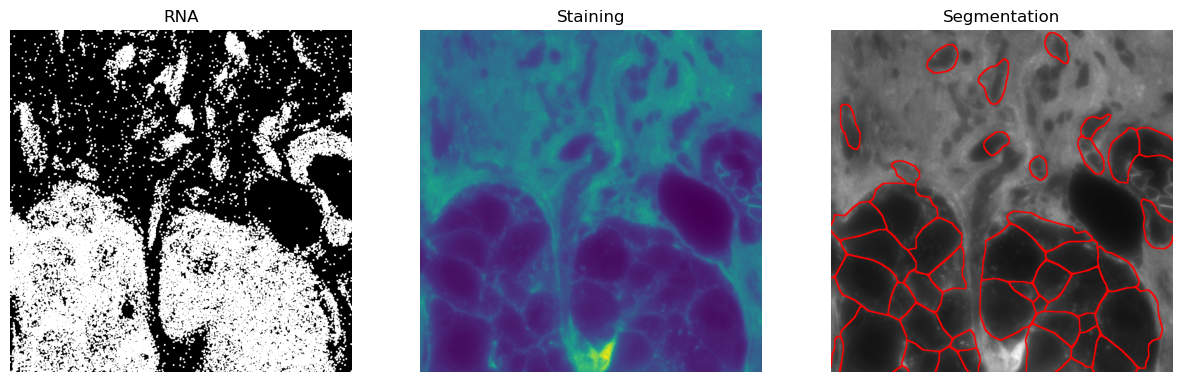

In [15]:
import matplotlib.pyplot as plt
from rna2seg.visualization import get_rna_img, get_staining_img, get_segmentation_img

# Parameters
key_segmentation="rna2seg_test"
bounds = [2000, 3000, 3000, 4000,] # xmin, ymin, xmax, ymax
staining_id = 1 # Staining to plot

# Get images
rna = get_rna_img(dataset, bounds, key_transcripts=points_key,)
image = get_staining_img(dataset, bounds)
seg = get_segmentation_img(dataset, image[staining_id], bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id])
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()
